In [1]:
# try:
# from sklearn.metrics import ndcg_score
# import cma
# from pyswarm import pso
# from openpyxl.utils import get_column_letter
# from skopt import gp_minimize
# from skopt.space import Real
# from deap import base, creator, tools, algorithms
# except ModuleNotFoundError:
# %pip install cma
# %pip install pyswarm
# %pip install openpyxl
# %pip install scikit-optimize
# %pip install deap
# from sklearn.metrics import ndcg_score
# import cma
# from pyswarm import pso
# from openpyxl.utils import get_column_letter
# from skopt import gp_minimize
# from skopt.space import Real
# from deap import base, creator, tools, algorithms


import os
import csv

# from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
import seaborn as sns
import requests

# import openpyxl
# from urllib.parse import urlparse, parse_qs, unquote
import pandas as pd

from rank import ndcg_loss

Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4465 sha256=4af06a9cb6e9f979ec13e43cc2b43f09745e2ae96e421192c6c7d218fb34a29b
  Stored in directory: /home/ubuntu/.cache/pip/wheels/93/15/89/3970ef96abd6123028010a90f007c4e6a2bed700db0aa2d36a
Successfully built pyswarm
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# extract the parameters for qual, pop, time, rate determined by the algorithms

root_dir = "results"
output_csv = "results_summary.csv"

csv_header = (
    ["method_number", "method"]
    + [f"var{i}" for i in range(2, 11)]
    + ["qual", "pop", "time", "rate"]
)

data_rows = []

# Traverse directories and extract data
for method_number in os.listdir(root_dir):
    method_number_path = os.path.join(root_dir, method_number)

    if not os.path.isdir(method_number_path):
        continue

    for method in os.listdir(method_number_path):
        method_path = os.path.join(method_number_path, method)

        for root, dirs, files in os.walk(method_path):
            if "stdout" not in files:
                continue  # Skip if no stdout file

            parts = root.split("/")

            try:
                values = [float(parts[i + 1]) for i in range(5, len(parts) - 1, 2)]
            except ValueError:
                print(f"Skipping invalid folder: {root}")
                continue  # Skip invalid folders

            # Read stdout file
            stdout_path = os.path.join(root, "stdout")
            with open(stdout_path, "r") as f:
                content = f.read().strip()

                # Extract output variables
                output_values = [
                    None
                ] * 4  # Default: 4 None values (qual, pop, time, rate)

                for line in content.split("\n"):  # Search for "Optimized weights"
                    if "Optimized weights" in line:
                        weights = (
                            line.split(":")[-1]
                            .strip()
                            .strip("[]")
                            .replace(",", "")
                            .split()
                        )
                        try:
                            output_values = [float(w) for w in weights]
                        except ValueError:
                            print(
                                f"Skipping invalid weights in {stdout_path}: {weights}"
                            )
                            break  # Skip this file if conversion fails
                        break  # Stop after finding the first occurrence

                # Ensure exactly 4 values (qual, pop, time, rate)
                while len(output_values) < 4:
                    output_values.append(None)

                data_rows.append([method_number, method] + values + output_values)

# Write to CSV
with open(output_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(csv_header)
    writer.writerows(data_rows)

print(f"Results saved to {output_csv}")

FileNotFoundError: [Errno 2] No such file or directory: 'results'

In [9]:
# run:
# git checkout ranking-model
# cargo xtask indexer
# cargo xtask server

# Import test data set
# the file is located in the folder Ranking \\gruppende\umwelt.info\int\Zusammenarbeit\Ranking
# It was created as "ranking_test.xlsx" using metadata/notebooks/ranking_create_ranking_table_landpage.ipynb and then manually filled with human judged rankings ('ranking_test_landing_page_gesamt.xlsx').
df = pd.read_excel("ranking_test_time_all.xlsx")
session = requests.Session()

In [36]:
# Load the created CSV file
csv_file = "results_summary.csv"
output_param = pd.read_csv(csv_file)

# Adjust column shifts for 'cmaes' method because it has less parameters
mask_cmaes = output_param["method"] == "cmaes"

output_param.loc[mask_cmaes, ["qual", "pop", "time", "rate"]] = output_param.loc[
    mask_cmaes, ["var7", "var8", "var9", "var10"]
].values

# Drop unnecessary var8-var11 for 'cmaes' (since they are now in qual-pop-time-rate)
output_param.loc[mask_cmaes, ["var7", "var8", "var9", "var10"]] = None

# Convert all numeric columns to float
numeric_cols = ["qual", "pop", "time", "rate"] + [f"var{i}" for i in range(2, 11)]
output_param[numeric_cols] = output_param[numeric_cols].astype(float)

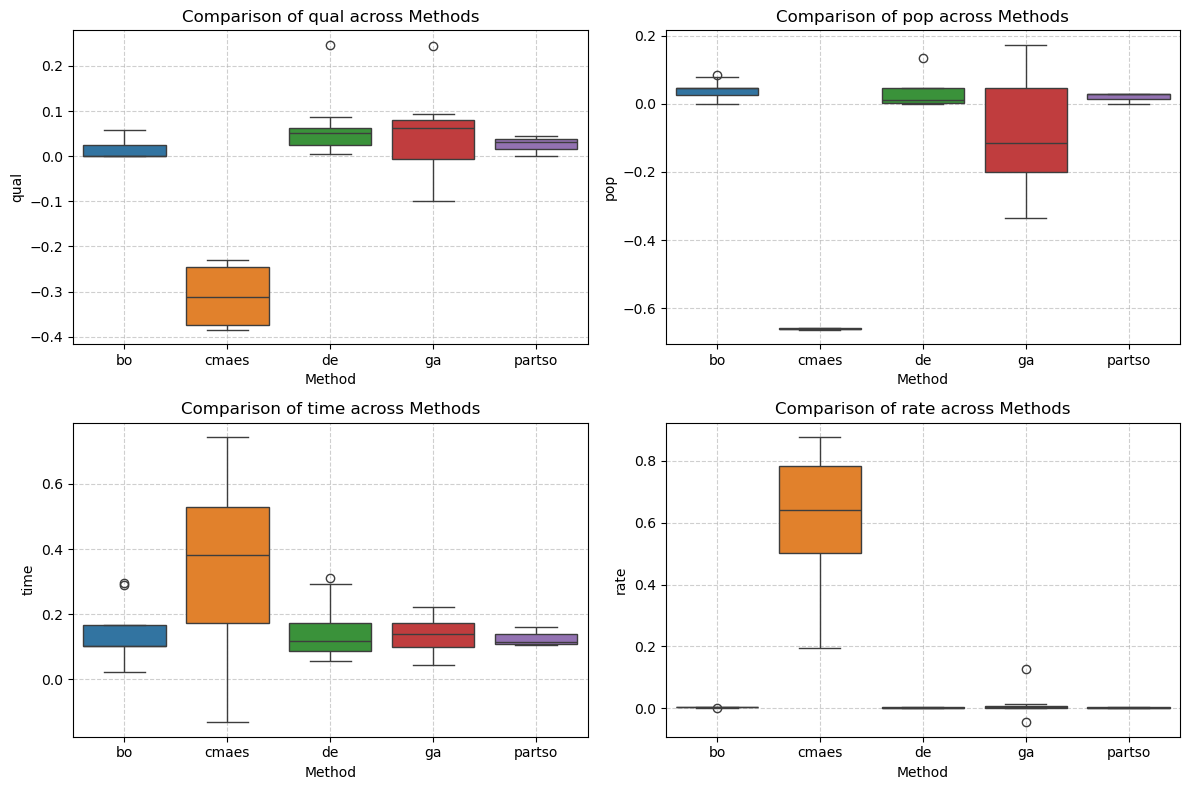

In [38]:
# Convert method column to categorical
output_param["method"] = output_param["method"].astype("category")

output_vars = ["qual", "pop", "time", "rate"]

# Filter out rows where any of the output_vars contain NaN
output_param_clean = output_param.dropna(subset=output_vars)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # Convert 2D array of axes into a 1D array for easy indexing

for i, var in enumerate(output_vars):
    sns.boxplot(
        data=output_param_clean,
        x="method",
        y=var,
        ax=axes[i],
        hue="method",
        legend=False,
    )
    axes[i].set_title(f"Comparison of {var} across Methods")
    axes[i].set_xlabel("Method")
    axes[i].set_ylabel(var)
    axes[i].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [41]:
# Retrieve corresponding ndcg for each run

# Filter out rows where any of the output_vars contain NaN
output_param = output_param.dropna(subset=output_vars)

# Ensure columns exist
if not all(col in output_param.columns for col in ["qual", "pop", "time", "rate"]):
    raise ValueError("Missing required parameter columns in CSV!")


def calculate_ndcg(row):
    return ndcg_loss(row["qual"], row["pop"], row["time"], row["rate"], df)


output_param["ndcg_loss"] = output_param.apply(calculate_ndcg, axis=1)

output_param.to_csv("results_summary_with_ndcg.csv", index=False)

/tmp/ipykernel_304136/208477722.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_param["ndcg_loss"] = output_param.apply(calculate_ndcg, axis=1)


In [42]:
# Find best run
output_param = pd.read_csv("results_summary_with_ndcg.csv")

positive_subset = output_param[
    (output_param["qual"] >= 0)
    & (output_param["pop"] >= 0)
    & (output_param["time"] >= 0)
    & (output_param["rate"] >= 0)
]

# Ensure ndcg_loss is numeric
positive_subset["ndcg_loss"] = positive_subset["ndcg_loss"].astype(float)

# Sort to find the best set of parameters
best_run = positive_subset.loc[
    positive_subset["ndcg_loss"].idxmin()
]  # Find the row with the lowest loss

print("Best run:")
print(best_run)

Best run:
method_number            1
method              partso
var2                   0.4
var3                   0.0
var4                  0.25
var5                   0.0
var6                   0.5
var7                   0.0
var8                 0.004
var9                  40.0
var10                  0.5
qual              0.032541
pop                0.02772
time              0.104043
rate               0.00046
ndcg_loss       -52.817966
Name: 10, dtype: object


/tmp/ipykernel_304136/3381693772.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_subset["ndcg_loss"] = positive_subset["ndcg_loss"].astype(float)


In [50]:
positive_subset_sorted = positive_subset.sort_values(by="ndcg_loss", ascending=True)
positive_subset_sorted

method_number  method  var2  var3   var4  var5  var6  var7   var8  var9  \
17              1   cmaes   0.1   0.1  0.001   0.1  50.0   NaN    NaN   NaN   
14              1   cmaes   0.1   0.1  0.001   0.3  30.0   NaN    NaN   NaN   
12              1   cmaes   0.1   0.1  0.001   0.2  30.0   NaN    NaN   NaN   
16              1   cmaes   0.1   0.1  0.001   0.1  30.0   NaN    NaN   NaN   
15              1   cmaes   0.1   0.1  0.001   0.3  50.0   NaN    NaN   NaN   
13              1   cmaes   0.1   0.1  0.001   0.2  50.0   NaN    NaN   NaN   
10              1  partso   0.4   0.0  0.250   0.0   0.5   0.0  0.004  40.0   
9               1  partso   0.4   0.0  0.250   0.0   0.5   0.0  0.004  30.0   
22              1      ga   0.4   0.0  0.250   0.0   0.5   0.0  0.004   0.3   
0               1      bo   0.4   0.0  0.250   0.0   0.5   0.0  0.004  30.0   
25              1      ga   0.4   0.0  0.250   0.0   0.5   0.0  0.004   0.1   
31              1      de   0.4   0.0  0.250   0.0   0.5   0.0  0.004   0.5   
32              1      de   0.4   0.0  0.250   0.0   0.5   0.0  0.004   1.0   
29              1      de   0.4   0.0  0.250   0.0   0.5   0.0  0.004   0.5   
11              1  partso   0.4   0.0  0.250   0.0   0.5   0.0  0.004  50.0   
24              1      ga   0.4   0.0  0.250   0.0   0.5   0.0  0.004   0.1   
7               1      bo   0.4   0.0  0.250   0.0   0.5   0.0  0.004  50.0   
20              1      ga   0.4   0.0  0.250   0.0   0.5   0.0  0.004   0.3   
18              1      ga   0.4   0.0  0.250   0.0   0.5   0.0  0.004   0.2   
23              1      ga   0.4   0.0  0.250   0.0   0.5   0.0  0.004   0.1   
6               1      bo   0.4   0.0  0.250   0.0   0.5   0.0  0.004  50.0   
3               1      bo   0.4   0.0  0.250   0.0   0.5   0.0  0.004  40.0   
2               1      bo   0.4   0.0  0.250   0.0   0.5   0.0  0.004  30.0   
5               1      bo   0.4   0.0  0.250   0.0   0.5   0.0  0.004  40.0   
33              1      de   0.4   0.0  0.250   0.0   0.5   0.0  0.004   1.0   
30              1      de   0.4   0.0  0.250   0.0   0.5   0.0  0.004   0.5   
34              1      de   0.4   0.0  0.250   0.0   0.5   0.0  0.004   1.0   
26              1      de   0.4   0.0  0.250   0.0   0.5   0.0  0.004   1.5   
19              1      ga   0.4   0.0  0.250   0.0   0.5   0.0  0.004   0.2   
4               1      bo   0.4   0.0  0.250   0.0   0.5   0.0  0.004  40.0   
8               1      bo   0.4   0.0  0.250   0.0   0.5   0.0  0.004  50.0   
28              1      de   0.4   0.0  0.250   0.0   0.5   0.0  0.004   1.5   
21              1      ga   0.4   0.0  0.250   0.0   0.5   0.0  0.004   0.3   
1               1      bo   0.4   0.0  0.250   0.0   0.5   0.0  0.004  30.0   
27              1      de   0.4   0.0  0.250   0.0   0.5   0.0  0.004   1.5   

    var10      qual       pop      time      rate  ndcg_loss  
17    NaN -0.229814 -0.658307  0.266027  0.195647 -52.923691  
14    NaN -0.236552 -0.663251  0.143692  0.877329 -52.913527  
12    NaN -0.348020 -0.659473  0.499186  0.823750 -52.881047  
16    NaN -0.274628 -0.661396  0.744035  0.462465 -52.879361  
15    NaN -0.385215 -0.664198  0.539066  0.665054 -52.875657  
13    NaN -0.383883 -0.657914 -0.132437  0.620109 -52.830553  
10    0.5  0.032541  0.027720  0.104043  0.000460 -52.817966  
9     0.7  0.000014  0.000228  0.115533  0.000453 -52.793949  
22    0.6 -0.063119 -0.180656  0.043634  0.000537 -52.734845  
0   100.0  0.058092  0.047225  0.103723  0.001138 -52.669138  
25    0.6  0.244248 -0.224266  0.115992  0.013968 -52.655824  
31   20.0  0.061101  0.012655  0.098735  0.000567 -52.592194  
32   30.0  0.024073  0.011354  0.118819  0.000275 -52.591149  
29   30.0  0.027027  0.048111  0.082947  0.000181 -52.585653  
11    0.5  0.044798  0.027763  0.160343  0.003512 -52.585114  
24    0.4 -0.098587 -0.192467  0.222195  0.126370 -52.561292  
7   123.0  0.043172  0.000000  0.168158  0.002756 -52.552663  
20    0.5  0.093351 -0.33

In [52]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=output_param, x="method", y="ndcg_loss", palette="Set2")
plt.title("Comparison of NDCG Loss Across Methods")
plt.xlabel("Optimization Method")
plt.ylabel("NDCG Loss (Lower is Better)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

/tmp/ipykernel_304136/2063664953.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=output_param, x="method", y="ndcg_loss", palette="Set2")


In [53]:
best_params = positive_subset.loc[
    positive_subset["ndcg_loss"].idxmin(), ["method", "qual", "pop", "time", "rate"]
]
print("Best Parameters Found:")
print(best_params)

Best Parameters Found:
method      partso
qual      0.032541
pop        0.02772
time      0.104043
rate       0.00046
Name: 10, dtype: object


In [54]:
# Conversion from relative to absolute values

d = {
    "Algorithm": ["Bayesian optimization"],
    "Param. A (Quality)": [best_params[1]],
    "Param. B (Popularity)": [best_params[2]],
    "Param. C (Time)": [best_params[3]],
    "Param. D (Rate)": [best_params[4]],
}
df_param = pd.DataFrame(d)

df_param["BM25"] = df_param.apply(
    lambda row: 1
    / (
        1
        + row["Param. A (Quality)"]
        + row["Param. B (Popularity)"]
        + row["Param. C (Time)"]
    ),
    axis=1,
)
df_param["alpha"] = df_param.apply(
    lambda row: row["Param. A (Quality)"]
    / (
        1
        + row["Param. A (Quality)"]
        + row["Param. B (Popularity)"]
        + row["Param. C (Time)"]
    ),
    axis=1,
)
df_param["beta"] = df_param.apply(
    lambda row: row["Param. B (Popularity)"]
    / (
        1
        + row["Param. A (Quality)"]
        + row["Param. B (Popularity)"]
        + row["Param. C (Time)"]
    ),
    axis=1,
)
df_param["gamma"] = df_param.apply(
    lambda row: row["Param. C (Time)"]
    / (
        1
        + row["Param. A (Quality)"]
        + row["Param. B (Popularity)"]
        + row["Param. C (Time)"]
    ),
    axis=1,
)

# Comparison of weighting values for each algorithm
print(df_param)

               Algorithm  Param. A (Quality)  Param. B (Popularity)  \
0  Bayesian optimization            0.032541                0.02772   

   Param. C (Time)  Param. D (Rate)      BM25     alpha      beta    gamma  
0         0.104043          0.00046  0.858882  0.027949  0.023808  0.08936  


/tmp/ipykernel_304136/267389815.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Param. A (Quality)': [best_params[1]],
/tmp/ipykernel_304136/267389815.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Param. B (Popularity)': [best_params[2]],
/tmp/ipykernel_304136/267389815.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Param. C (Time)': [best_params[3]],
/tmp/ipykernel_304136/267389815.py:8: FutureWarning: Series.__ge